In [1]:
import pandas as pd
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import backend as K
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
# Define our classes
class NeuralNetworkFactory:
    def __init__(self):
        pass
    def build_sequential_model(self, nodes, activations, input_size):
        model = Sequential()
        # First layer is the input layer
        model.add(Dense(nodes[0], input_dim=input_size, activation=activations[0]))
        # After the first, read all nodes and activations given to build the DFF model
        for i in range(1, len(nodes)):
            model.add(Dense(nodes[i], activation=activations[i]))
        return model
    
class CategoricalEnsemble:
    def __init__(self, ensemble_size, num_labels, input_shape, losses, optimizers, metrics, learning_rates, voting_method='sum'):
        # Number of models in the ensemble
        self.ensemble_size = ensemble_size
        # How voting will be conducted. "sum" or "count"
        self.voting_method = voting_method
        # The ensemble's factory for producing models
        self.factory = NeuralNetworkFactory()
        # Build models with proper hyperparameters
        self.create_models(num_labels, input_shape, losses, optimizers, metrics, learning_rates)
    def create_models(self, num_labels, input_size, losses, optimizers, metrics, learning_rates):
        self.models = []
        for i in range(self.ensemble_size):
            # To keep things interesting, define each DFF model as a random depth! This could be subbed in as a given list just like other hyperparameters
            numNeurons = random.randint(3, 10)
            # Build up from 8 nodes -> 2**1/2 numNeurons, then back down
            nodes = [2**(n + 3) if (n <= (numNeurons / 2)) else 2**(numNeurons - n + 3) for n in range(numNeurons)]
            # Final node should be ready for a softmax of all possible labels
            nodes[-1] = num_labels
            # Hardcode in RELU for simplicity
            activations = ['relu' for n in range(numNeurons)]
            # Final layer should be a softmax for categorical classification
            activations[-1] = 'softmax'
            # Compile and add to the list
            self.models.append(
                self.compile_model(
                    self.factory.build_sequential_model(nodes, activations, input_size), 
                losses[i], optimizers[i], metrics[i], learning_rates[i])
            )
    def compile_model(self, model, loss, optimizer, metrics, learning_rate):
        # Wrapper function for model compilation. Also allows manual setting of learning rate while keeping the string optimizer selection
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        K.set_value(model.optimizer.learning_rate, learning_rate)
        return model
    def fit_models(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        # Keep history of each model's fit for future use...
        self.histories = []
        # Count and print to keep track of where we are!
        count = 0
        for model in self.models:
            print("Training Model #", count)
            count += 1
            history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))
            self.histories.append(history)
        return
    def show_models(self):
        # Wrapper for model.summary() function for some mild convenience now, and potential to display other information later
        for model in self.models:
            print(model.summary())
        return
    def evaluate_models(self, X_test, Y_test):
        # Wrapper for model.evaluate() for some mild convenience now, and potential to display more information later
        # Hold onto accuracies to view later
        self.accuracies = []
        for model in self.models:
            _, accuracy = model.evaluate(X_test, Y_test)
            self.accuracies.append(accuracy)
        return
    def poll_models(self, X_test):
        # Poll the ensemble to select the best option.
        # Begin by stacking each model's predictions onto each other, making a 3D array (n_elements x n_models x n_classes)
        polled_results = None
        # Simple way to track the first iteration. Not used after that, but doesn't take too many resources or time
        count = 0
        for model in self.models:
            y_pred = model.predict(X_test)
            if count == 0:
                polled_results = y_pred
                count += 1
            else:
                polled_results = np.dstack((polled_results, y_pred))
        # Sum method: add up all prediction probabilities from each model, and then select the largest
        if self.voting_method == 'sum':
            votes = np.sum(polled_results, axis=2)
            self.predictions = np.argmax(votes, 1)
            
        # Count method: determine the largest probability for each model, and then sum up the total
        # In a tie, the lowest class number is selected (a product of scipy.stats.mode())
        elif self.voting_method == 'count':
            votes = np.argmax(polled_results, axis=1)
            self.predictions = stats.mode(votes, axis=1)[0].T[0]
            
        return

In [3]:
# Read in the data files
data_folder = 'data'
train = pd.read_csv(data_folder + '/train.csv')
test = pd.read_csv(data_folder + '/test.csv')
train.head()

,X000,X001,X002,X003,X004,X005,X006,X007,X008,X009,...,X384,X385,X386,X387,X388,X389,X390,X391,X392,Y
0,0.435294,0.568627,0.470588,0.239216,0.062745,0.003922,0.000000,0.000000,0.133333,0.321569,...,0.694118,0.000000,0.000000,0.000000,0.000000,0.000000,0.054902,0.243137,0.537255,5
1,0.290196,0.192157,0.098039,0.039216,0.011765,0.000000,0.000000,0.000000,0.482353,0.627451,...,0.278431,0.007843,0.019608,0.035294,0.054902,0.082353,0.133333,0.141176,0.098039,0
2,0.000000,0.000000,0.000000,0.000000,0.003922,0.027451,0.082353,0.184314,0.000000,0.000000,...,0.380392,0.007843,0.050980,0.164706,0.301961,0.400000,0.443137,0.415686,0.360784,4
3,0.745098,0.952941,0.870588,0.329412,0.035294,0.000000,0.000000,0.000000,0.000000,0.058824,...,0.000000,0.015686,0.211765,0.341176,0.800000,0.101961,0.000000,0.000000,0.000000,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9


In [4]:
# Adjust data to match the format we want for categorical classification
X = train.drop('Y', axis=1).values
X = X / X.max(axis=0)
Y = train['Y'].values
Y = to_categorical(Y)
X_test = test.drop('Y', axis=1).values
X_test = X_test / X.max(axis=0)
Y_truth = test['Y'].values
Y_test = to_categorical(Y_truth)

In [5]:
# Split train/val data -- validation size 20%
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [6]:
# Set parameters for our models
# Number of networks in our ensemble
ensemble_size = 5
# Number of possible labels in the set
num_labels = len(train['Y'].unique())
# Shape of the input. Really just 1D length of the input vector
input_shape = train.shape[1] - 1 # -1 because train.shape includes Y column
# Array of losses; each entry is for a different network. Currently set
#  as the same for each, but this can be modified depending on the problem
losses = ['categorical_crossentropy' for i in range(ensemble_size)]
# Array of optimizers; each entry is for a different network. Currently set
#  as the same for each, but this can be modified to test different ones
optimizers = ['adam' for i in range(ensemble_size)]
# Array of metrics reporting. Can be set so different networks report 
#  different metrics
metrics = [['accuracy'] for i in range(ensemble_size)]
# Array of learning rates. Currently set so each network has a slower 
#  learning rate
learning_rates = [10**(-1 * i) for i in range(ensemble_size)]

In [7]:
# Create the ensemble and confirm the desired number of models were created
ensemble = CategoricalEnsemble(ensemble_size, num_labels, input_shape, losses, optimizers, metrics, learning_rates, 'count')
len(ensemble.models)

5

In [9]:
# Fit the models in the ensemble!
epochs = 150
batch_size = 10
ensemble.fit_models(X_train, Y_train, X_val, Y_val, epochs=epochs, batch_size=batch_size)

Training Model # 0
Epoch 1/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5166 - accuracy: 0.0995 - val_loss: 2.7174 - val_accuracy: 0.0865
Epoch 2/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5152 - accuracy: 0.0997 - val_loss: 2.4936 - val_accuracy: 0.0997
Epoch 3/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5037 - accuracy: 0.0990 - val_loss: 2.4790 - val_accuracy: 0.1070
Epoch 4/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5249 - accuracy: 0.1023 - val_loss: 2.5131 - val_accuracy: 0.0967
Epoch 5/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5235 - accuracy: 0.1023 - val_loss: 2.3826 - val_accuracy: 0.1070
Epoch 6/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5106 - accuracy: 0.1013 - val_loss: 2.4579 - val_accuracy: 0.1170
Epoch 7/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5073 - accuracy: 0.0992 - val_lo

Epoch 57/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5182 - accuracy: 0.1008 - val_loss: 2.4449 - val_accuracy: 0.1070
Epoch 58/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.4994 - accuracy: 0.1022 - val_loss: 2.4075 - val_accuracy: 0.0997
Epoch 59/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.5130 - accuracy: 0.0970 - val_loss: 2.6393 - val_accuracy: 0.0967
Epoch 60/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5159 - accuracy: 0.0985 - val_loss: 2.3785 - val_accuracy: 0.1043
Epoch 61/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5063 - accuracy: 0.1017 - val_loss: 2.4395 - val_accuracy: 0.0865
Epoch 62/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5273 - accuracy: 0.1013 - val_loss: 2.5584 - val_accuracy: 0.1043
Epoch 63/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5212 - accuracy: 0.1023 - val_loss: 2.5589 -

2400/2400 [==============================] - 4s 2ms/step - loss: 2.5136 - accuracy: 0.0988 - val_loss: 2.5516 - val_accuracy: 0.1170
Epoch 114/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5152 - accuracy: 0.1060 - val_loss: 2.6608 - val_accuracy: 0.1170
Epoch 115/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5185 - accuracy: 0.1010 - val_loss: 2.5218 - val_accuracy: 0.1070
Epoch 116/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5148 - accuracy: 0.1033 - val_loss: 2.4563 - val_accuracy: 0.0923
Epoch 117/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5282 - accuracy: 0.0980 - val_loss: 2.5281 - val_accuracy: 0.1043
Epoch 118/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5113 - accuracy: 0.1007 - val_loss: 2.5585 - val_accuracy: 0.1042
Epoch 119/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.5183 - accuracy: 0.1030 - val_loss: 2.4536 - val_ac

2400/2400 [==============================] - 5s 2ms/step - loss: 2.3249 - accuracy: 0.1002 - val_loss: 2.3108 - val_accuracy: 0.0957
Epoch 19/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3238 - accuracy: 0.1027 - val_loss: 2.3233 - val_accuracy: 0.1042
Epoch 20/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3244 - accuracy: 0.1025 - val_loss: 2.3249 - val_accuracy: 0.0997
Epoch 21/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3253 - accuracy: 0.1023 - val_loss: 2.3156 - val_accuracy: 0.0957
Epoch 22/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3251 - accuracy: 0.1007 - val_loss: 2.3110 - val_accuracy: 0.1070
Epoch 23/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3238 - accuracy: 0.1060 - val_loss: 2.3189 - val_accuracy: 0.0967
Epoch 24/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3256 - accuracy: 0.1019 - val_loss: 2.3108 - val_accuracy

2400/2400 [==============================] - 4s 2ms/step - loss: 2.3242 - accuracy: 0.1034 - val_loss: 2.3386 - val_accuracy: 0.0997
Epoch 75/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3247 - accuracy: 0.1048 - val_loss: 2.3266 - val_accuracy: 0.0997
Epoch 76/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3247 - accuracy: 0.0974 - val_loss: 2.3249 - val_accuracy: 0.0923
Epoch 77/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3231 - accuracy: 0.1056 - val_loss: 2.3042 - val_accuracy: 0.1170
Epoch 78/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3245 - accuracy: 0.0971 - val_loss: 2.3492 - val_accuracy: 0.0997
Epoch 79/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3242 - accuracy: 0.1011 - val_loss: 2.3446 - val_accuracy: 0.0865
Epoch 80/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3253 - accuracy: 0.1042 - val_loss: 2.3141 - val_accuracy

Epoch 130/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3231 - accuracy: 0.0995 - val_loss: 2.3227 - val_accuracy: 0.1070
Epoch 131/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3253 - accuracy: 0.1007 - val_loss: 2.3117 - val_accuracy: 0.1043
Epoch 132/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3244 - accuracy: 0.1046 - val_loss: 2.3306 - val_accuracy: 0.0957
Epoch 133/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3248 - accuracy: 0.1045 - val_loss: 2.3323 - val_accuracy: 0.0997
Epoch 134/150
2400/2400 [==============================] - 4s 2ms/step - loss: 2.3247 - accuracy: 0.1001 - val_loss: 2.3106 - val_accuracy: 0.1042
Epoch 135/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3243 - accuracy: 0.1009 - val_loss: 2.3277 - val_accuracy: 0.0957
Epoch 136/150
2400/2400 [==============================] - 5s 2ms/step - loss: 2.3232 - accuracy: 0.1007 - val_loss: 2

Epoch 36/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4861 - accuracy: 0.4435 - val_loss: 1.5331 - val_accuracy: 0.4210
Epoch 37/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4914 - accuracy: 0.4423 - val_loss: 1.5507 - val_accuracy: 0.4258
Epoch 38/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4945 - accuracy: 0.4395 - val_loss: 1.4665 - val_accuracy: 0.4543
Epoch 39/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4974 - accuracy: 0.4392 - val_loss: 1.5491 - val_accuracy: 0.3920
Epoch 40/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4900 - accuracy: 0.4433 - val_loss: 1.5295 - val_accuracy: 0.4305
Epoch 41/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4854 - accuracy: 0.4422 - val_loss: 1.4687 - val_accuracy: 0.4460
Epoch 42/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4858 - accuracy: 0.4440 - val_loss: 1.4455 -

2400/2400 [==============================] - 3s 1ms/step - loss: 1.4728 - accuracy: 0.4447 - val_loss: 1.6141 - val_accuracy: 0.4117
Epoch 93/150
2400/2400 [==============================] - 4s 1ms/step - loss: 1.4677 - accuracy: 0.4447 - val_loss: 1.4817 - val_accuracy: 0.4428
Epoch 94/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4641 - accuracy: 0.4452 - val_loss: 1.4527 - val_accuracy: 0.4663
Epoch 95/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4721 - accuracy: 0.4453 - val_loss: 1.4708 - val_accuracy: 0.4607
Epoch 96/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4709 - accuracy: 0.4430 - val_loss: 1.5190 - val_accuracy: 0.4297
Epoch 97/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4717 - accuracy: 0.4457 - val_loss: 1.4638 - val_accuracy: 0.4482
Epoch 98/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4786 - accuracy: 0.4409 - val_loss: 1.4663 - val_accuracy

Epoch 148/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4699 - accuracy: 0.4453 - val_loss: 1.5261 - val_accuracy: 0.4410
Epoch 149/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4748 - accuracy: 0.4462 - val_loss: 1.5014 - val_accuracy: 0.4378
Epoch 150/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4716 - accuracy: 0.4439 - val_loss: 1.4719 - val_accuracy: 0.4525
Training Model # 3
Epoch 1/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.5004 - accuracy: 0.4408 - val_loss: 1.3839 - val_accuracy: 0.4857
Epoch 2/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.3176 - accuracy: 0.5145 - val_loss: 1.3180 - val_accuracy: 0.5142
Epoch 3/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.2559 - accuracy: 0.5427 - val_loss: 1.2980 - val_accuracy: 0.5233
Epoch 4/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.2102 - accuracy: 0.5659 - 

2400/2400 [==============================] - 3s 1ms/step - loss: 0.8051 - accuracy: 0.7144 - val_loss: 1.0270 - val_accuracy: 0.6490
Epoch 55/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8008 - accuracy: 0.7136 - val_loss: 0.9964 - val_accuracy: 0.6582
Epoch 56/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8024 - accuracy: 0.7157 - val_loss: 1.0227 - val_accuracy: 0.6570
Epoch 57/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7972 - accuracy: 0.7183 - val_loss: 1.0334 - val_accuracy: 0.6548
Epoch 58/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7958 - accuracy: 0.7155 - val_loss: 1.0210 - val_accuracy: 0.6605
Epoch 59/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7919 - accuracy: 0.7175 - val_loss: 1.0193 - val_accuracy: 0.6627
Epoch 60/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7903 - accuracy: 0.7203 - val_loss: 1.0309 - val_accuracy

2400/2400 [==============================] - 3s 1ms/step - loss: 0.7205 - accuracy: 0.7427 - val_loss: 1.1227 - val_accuracy: 0.6638
Epoch 111/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7231 - accuracy: 0.7398 - val_loss: 1.0888 - val_accuracy: 0.6605
Epoch 112/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7197 - accuracy: 0.7445 - val_loss: 1.1021 - val_accuracy: 0.6628
Epoch 113/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7189 - accuracy: 0.7417 - val_loss: 1.1158 - val_accuracy: 0.6555
Epoch 114/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7198 - accuracy: 0.7420 - val_loss: 1.0775 - val_accuracy: 0.6595
Epoch 115/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7173 - accuracy: 0.7452 - val_loss: 1.0931 - val_accuracy: 0.6615
Epoch 116/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7190 - accuracy: 0.7438 - val_loss: 1.1162 - val_ac

Epoch 16/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1655 - accuracy: 0.5955 - val_loss: 1.1870 - val_accuracy: 0.5827
Epoch 17/150
2400/2400 [==============================] - 2s 1ms/step - loss: 1.1576 - accuracy: 0.5991 - val_loss: 1.1806 - val_accuracy: 0.5883
Epoch 18/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1505 - accuracy: 0.6025 - val_loss: 1.1743 - val_accuracy: 0.5890
Epoch 19/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1438 - accuracy: 0.6040 - val_loss: 1.1717 - val_accuracy: 0.5873
Epoch 20/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1377 - accuracy: 0.6060 - val_loss: 1.1723 - val_accuracy: 0.5858
Epoch 21/150
2400/2400 [==============================] - 2s 1ms/step - loss: 1.1323 - accuracy: 0.6085 - val_loss: 1.1602 - val_accuracy: 0.5900
Epoch 22/150
2400/2400 [==============================] - 2s 1ms/step - loss: 1.1269 - accuracy: 0.6120 - val_loss: 1.1659 -

2400/2400 [==============================] - 2s 1ms/step - loss: 0.9930 - accuracy: 0.6628 - val_loss: 1.0730 - val_accuracy: 0.6270
Epoch 73/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9920 - accuracy: 0.6608 - val_loss: 1.0704 - val_accuracy: 0.6285
Epoch 74/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9893 - accuracy: 0.6632 - val_loss: 1.0728 - val_accuracy: 0.6270
Epoch 75/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9879 - accuracy: 0.6634 - val_loss: 1.0721 - val_accuracy: 0.6277
Epoch 76/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9864 - accuracy: 0.6632 - val_loss: 1.0670 - val_accuracy: 0.6333
Epoch 77/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9842 - accuracy: 0.6642 - val_loss: 1.0670 - val_accuracy: 0.6347
Epoch 78/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9832 - accuracy: 0.6658 - val_loss: 1.0629 - val_accuracy

2400/2400 [==============================] - 2s 1ms/step - loss: 0.9238 - accuracy: 0.6878 - val_loss: 1.0399 - val_accuracy: 0.6447
Epoch 129/150
2400/2400 [==============================] - 2s 1ms/step - loss: 0.9236 - accuracy: 0.6880 - val_loss: 1.0341 - val_accuracy: 0.6492
Epoch 130/150
2400/2400 [==============================] - 2s 1ms/step - loss: 0.9222 - accuracy: 0.6880 - val_loss: 1.0348 - val_accuracy: 0.6467
Epoch 131/150
2400/2400 [==============================] - 2s 1ms/step - loss: 0.9211 - accuracy: 0.6883 - val_loss: 1.0296 - val_accuracy: 0.6522
Epoch 132/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9208 - accuracy: 0.6896 - val_loss: 1.0303 - val_accuracy: 0.6543
Epoch 133/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9198 - accuracy: 0.6892 - val_loss: 1.0340 - val_accuracy: 0.6510
Epoch 134/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.9198 - accuracy: 0.6893 - val_loss: 1.0287 - val_ac

In [10]:
# Display the model summaries for reference
ensemble.show_models()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 3152      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2

In [12]:
ensemble.poll_models(X_val)
# Validation Accuracy
print("Validation Accuracy:")
Y_val_truth = np.argmax(Y_val, axis=1)
print(sum(ensemble.predictions == Y_val_truth) / len(Y_val_truth))

Validation Accuracy:
0.657


In [13]:
# Perform polling to "stack" the model predictions and then vote on the winners!
# This has two options currently: sum and count
# Sum -- adds up all probabilities for each model, for each class, and takes the largest
# Count -- determines the selected class from each model, and polls for the highest count of votes. Will choose the lower number in a tie
ensemble.poll_models(X_test)

In [14]:
# Accuracy of the ensemble's combined prediction
print("Test Accuracy:")
print(sum(ensemble.predictions == Y_truth) / len(Y_truth))

Test Accuracy:
0.5821


In [15]:
# Accuracy scores for each model in the ensemble
print("Test Accuracies for each model:")
ensemble.evaluate_models(X_test, Y_test)
print("\n\n", ensemble.accuracies)
print("Validation Accuracies for each model:")
ensemble.evaluate_models(X_val, Y_val)
print("\n\n", ensemble.accuracies)

Test Accuracies for each model:
313/313 [==============================] - 0s 1ms/step - loss: 1.3396 - accuracy: 0.5757


 [0.09830000251531601, 0.10130000114440918, 0.435699999332428, 0.5708000063896179, 0.5756999850273132]
Validation Accuracies for each model:
188/188 [==============================] - 0s 1ms/step - loss: 1.0251 - accuracy: 0.6588


 [0.09566666930913925, 0.10700000077486038, 0.45249998569488525, 0.6631666421890259, 0.6588333249092102]


Model # 0


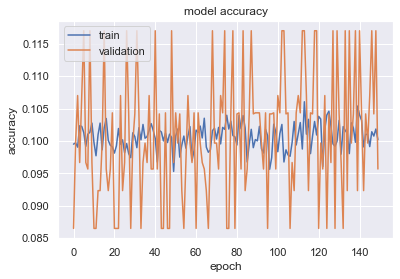

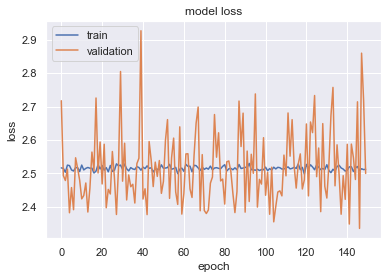

Model # 1


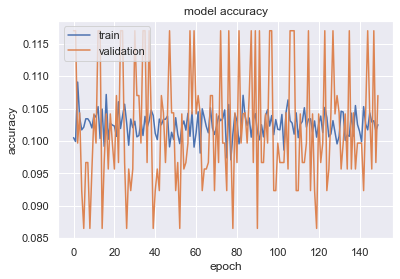

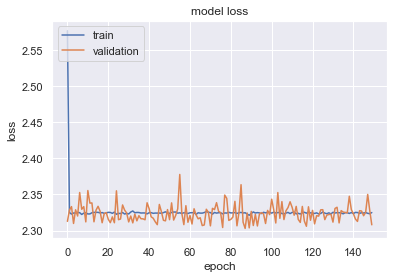

Model # 2


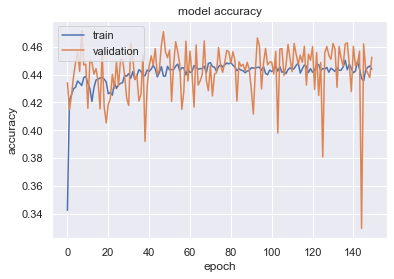

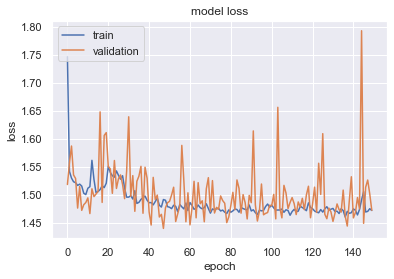

Model # 3


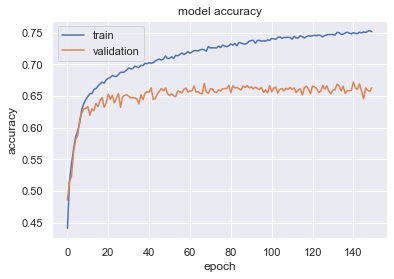

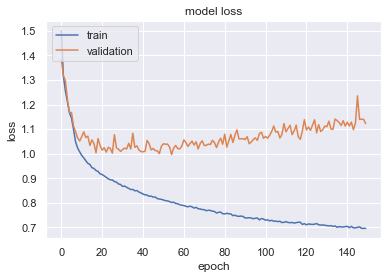

Model # 4


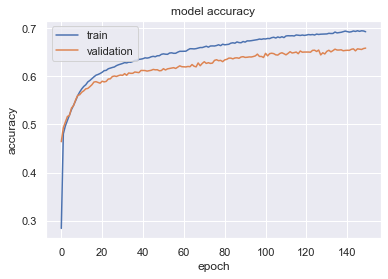

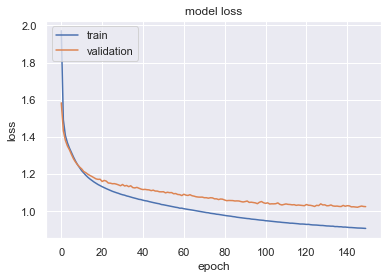

In [16]:
# Print Accuracy (and Val Accuracy) and Loss (and Val Loss) for each model!
count = 0
for history in ensemble.histories:
    print("Model #", count)
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    count += 1